# MNIST classification with numpy NN implementation


In [1]:
import numpy as np 
import idx2numpy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt #per dibuixar
import seaborn as sns

# Define abstract class layer


In [2]:
class layer():
    def __init__(self):
        self.input= None
        self.output= None
    
    
    def forward(self):
        pass
    
    def backward(self):
        pass
    
    def update_parametres(self):
        pass

# Define linear


In [3]:
class linear_layer():
    def __init__(self, input_dimensions, output_dimensions):
        self.W = 2 * np.random.rand(input_dimensions, output_dimensions) - 1
        self.B = np.random.rand(1, output_dimensions)
          
    def forward(self, x):
        self.x = x
        return x @ self.W + self.B
    
    def backward(self, error):
        m= error.shape[0]
        self.dW =1/m *(self.x.T @ error*0.03)
        self.dB =1/m*(error.sum(axis=0))
        return error @ np.transpose(self.W)
    
    def update_parametres(self, lr):
        self.W = self.W - lr * self.dW
        self.B = self.B - lr * self.dB
        

## Define activation layers and input


In [4]:
class Relu_layer():
    def __init__(self):
        pass
    
    def forward(self,x):
        self.Z=np.maximum(0,x)
        return self.Z
    
    def backward(self,error):
        return error * (self.Z > 0)
    
    def update_parametres(self, lr):
        return True
    
    
class input_layer():
    def __init__(self, input_size):
        self.input_size= input_size
        
    
    def forward(self,x):
        return x
    
    def backward(self,error):
        return error
    
    def update_parametres(self, lr):
        return True
    
    
class flatten_layer():
    def __init__(self):
        pass
    
    def forward(self,x):
        # (bs, 28, 28) -> (bs, 784)
        return x.reshape(x.shape[0], x.shape[1]*x.shape[2])
    
    def backward(self,error):
        pass
    
    def update_parametres(self, lr):
        pass

## Softmax


In [5]:
# Converteix els logits en probabilitats per a cada classe (0-9),
# on la suma total de totess les probabilitats és 1,
# Ex: [0.7, 0.2, 0.1] -> predicció classe 1 amb prob 0.7
def softmax(x):
    exp_x= np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x - np.max(x, axis=1, keepdims=True))

## Model design


In [6]:
class NN_model():
    def __init__(self):
        self.sequencial= [flatten_layer(),
                        input_layer(784),
                        linear_layer(784,100),
                        Relu_layer(),
                        linear_layer(100,10)]
        
    def forward(self,x):
        for layer in self.sequencial:
            y= layer.forward(x)
            x= y
        return y
    
    def backward(self, error):
        for layer in np.flip(self.sequencial):
            y = layer.backward(error)
            error= y
        return y
        
    def update_parametres(self, learning_rate=0.03):
        for layer in self.sequencial:
            layer.update_parametres(learning_rate)
        
model= NN_model()


## Train test loop


In [7]:
def train_step(model, x, y, lr, verbose=True):
    # x es un batch de dades
    # yp = [[1,0,0], [0,1,0], [0,0,1]]
    # y = [0, 1, 2]
    logits=model.forward(x)
    #print(logits)
    y_real = one_hot(y, 10)
    error= 2*(logits-y_real)-1
    model.backward(error)
    model.update_parametres(learning_rate= lr)
    cost= np.sum((y_real-logits)**2) /len(y_real)
    if verbose:
        print('resultat de la funció de cost:',cost)


def train_loop(model, dataloader, lr, verbose=True):
    for i in np.arange(0,len(dataloader), dataloader.bs):
        x_batch, y_batch = dataloader[i: i+dataloader.bs]
        train_step(model, x_batch, y_batch, lr, verbose)



def test_step(model, x, y, verbose=False):
    logits=model.forward(x)
    accuracy=np.sum(np.argmax(logits, axis=1) == y)/len(y)
    print(f'este es el acuracy:{accuracy}')
    return logits
        
        
def test_loop(model, dataloader, verbose=False):
    for i in np.arange(0, len(dataloader), dataloader.bs):
        x_batch, y_batch = dataloader[i: i + dataloader.bs]
        y_pred = test_step(model, x_batch, y_batch, verbose)

        # Calcular la matriz de confusión
        cm = confusion_matrix(y_batch, y_pred.argmax(axis=1))

        # Mostrar la matriz de confusión como un heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicciones")
        plt.ylabel("Etiquetas verdaderas")
        plt.title("Matriz de Confusión")
        return plt

        


def one_hot(y, num_classes):
  y_hat=np.zeros((len(y), num_classes))
  y_hat[np.arange(len(y)),y]=1
  return y_hat

## Data processing


In [8]:
class Dataloader():
  def __init__(self, x, y, bs, shuffle=True):
    self.bs= bs
    #np.arange(len(y)) = np.range(range(len(y)))
    randomizer= np.arange(len(y))
    
    if shuffle:
      np.random.shuffle(randomizer)
      
    self.x= x[randomizer]
    self.y= y[randomizer]
    
  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, idx):
    return self.x[idx]/255, self.y[idx]
  
  def __iter__(self):
    return self
  
  def __next__(self):
    pass
    
  def init_dl(x, y, bs):
    ds = np.array[x, y]
    ds.shuffle()
    dl=ds.split(len(x)/bs)
    return dl
  
  


## MAIN


In [ ]:



def main(hidden_size=100, batch_size=500, learning_rate=0.03, epoches=5, verbose=True):
    
    x_train= idx2numpy.convert_from_file('./Dataset/train-images.idx3-ubyte')
    y_train= idx2numpy.convert_from_file('./Dataset/train-labels.idx1-ubyte')

    x_test= idx2numpy.convert_from_file('./Dataset/t10k-images.idx3-ubyte')
    y_test= idx2numpy.convert_from_file('./Dataset/t10k-labels.idx1-ubyte')
    
    train_dataloader= Dataloader(x_train, y_train, batch_size)
    test_dataloader= Dataloader(x_test, y_test, batch_size)
     
    #model= NN_model(784,hidden_size,10)
    model= NN_model()
    
    
    for epoche in range(epoches):
        train_loop(model, train_dataloader, learning_rate)
    plt= test_loop(model, test_dataloader, verbose=False)
    plt.show()
    
    

resultat de la funció de cost: 3812.9410512245495
resultat de la funció de cost: 8062.714296072993
resultat de la funció de cost: 8255.624411473662
resultat de la funció de cost: 630.9719191247138
resultat de la funció de cost: 429.08301582740273
resultat de la funció de cost: 371.1307372133397
resultat de la funció de cost: 331.8187443571661
resultat de la funció de cost: 300.85251516052455
resultat de la funció de cost: 263.5854143585478
resultat de la funció de cost: 258.2722318430938
resultat de la funció de cost: 231.85226156332484
resultat de la funció de cost: 231.70165073938412
resultat de la funció de cost: 226.5993335135128
resultat de la funció de cost: 210.75108813129202
resultat de la funció de cost: 210.92088658521968
resultat de la funció de cost: 188.80777713185736
resultat de la funció de cost: 184.33808565034826
resultat de la funció de cost: 181.2419592830284
resultat de la funció de cost: 161.07177847843664
resultat de la funció de cost: 160.54845286003368
resultat 

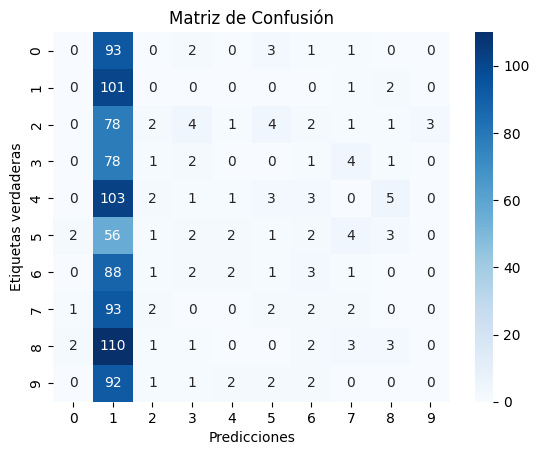

In [10]:
main(hidden_size=100, batch_size=1000, learning_rate=0.03, epoches=50, verbose=False)